<a href="https://colab.research.google.com/github/omeruncu1/Credit-Card-Approval-Prediction/blob/main/Credit_Card_Approval_Ensemble_Method_LightGBM_XGB_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-approval-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F426827%2F1031720%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240812%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240812T231759Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D52926eae3f0731853dadc0138c3080d9e6532ed09256e63ff3b25e32ef99578f9b5269aea2f124880b770da32c1ec8391a0384cafa02ccbc23c840db05652e78a7e8a387ffbf73e34f646dc1eb2f8dd763f2518fb7b161abeeb190c029bc8e6c00dafa5c0afe643f8a5dc8be4d5958d7a8b5a745fd459a0a792c04e68b8a52e36d613f25319a29eb3865dee7e20e6f83e441c14d95dd3106b3e95f66c9e78c63fcebf825d3f09f5d17b76aecbd8168db57211e086cdee4db7643e6252f8e5e554c673cbc19e7b6dcc1ac217af4e7dbe2b23241bdf0a8514cbd256fbc4b87f26089e119ff3a857bab31b0dd871378803f5470f81b2b3fc6f7f30e39cb02737d9d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Introduction:
> - This study is a comprehensive machine learning project aimed at predicting the likelihood of credit card application approvals. In the project, I used a multi-stage approach including data preparation, feature engineering, model selection, hyperparameter optimization, and ensemble methods. Initially, two separate datasets (application records and credit records) were merged and thoroughly preprocessed. Using feature engineering techniques, I created a scenario, derived new features from existing data, and developed a credit scoring system. Using this scoring system, I obtained a Target Label according to the scenario. Various machine learning models were tested, and the best-performing models were selected for hyperparameter optimization. Using the best models, I evaluated ensemble methods, chose the best method to combine the models, and finally addressed the class imbalance issue to create the final model.

Thank you in advance for your support.

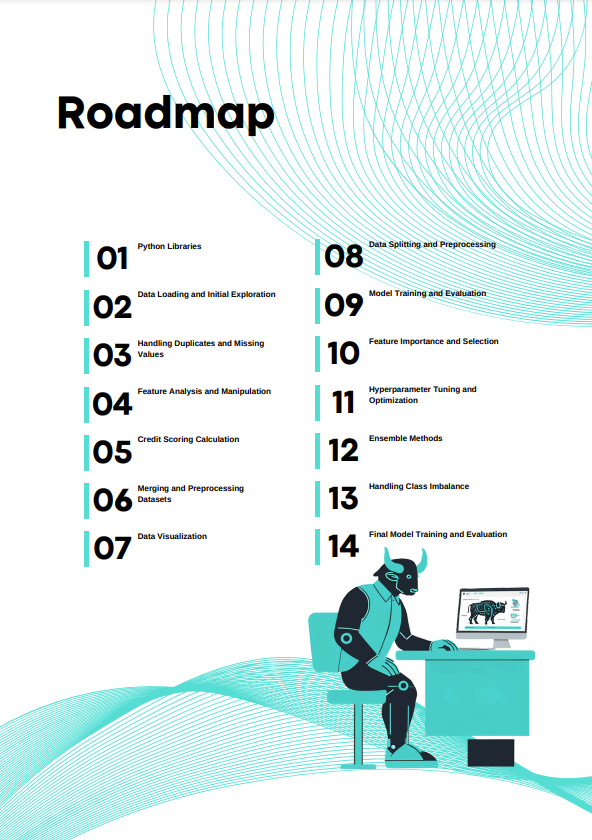

## Content
1. [Python Libraries](#1)
1. [Data Loading and Initial Exploration](#2)
1. [Handling Duplicates and Missing Values](#3)
1. [Feature Analysis and Manipulation](#4)
1. [Credit Scoring Calculation](#5)
1. [Merging and Preprocessing Datasets](#6)
1. [Data Visualization](#7)
1. [Data Splitting and Preprocessing](#8)
1. [Model Training and Evaluation](#9)
1. [Feature Importance and Selection](#10)
1. [Hyperparameter Tuning and Optimization](#11)
1. [Ensemble Methods](#12)
1. [Handling Class Imbalance](#13)
1. [Final Model Training and Evaluation](#14)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="1"></a>
## 1. Python Libraries

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Typing and Pretty Printing
from typing import List, Dict, Any
from pprint import pprint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

# Pipelines and Column Transformation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Decision Trees
from sklearn.tree import DecisionTreeRegressor, export_text

# Model Evaluation
from sklearn.metrics import make_scorer, accuracy_score, classification_report, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, matthews_corrcoef, balanced_accuracy_score, precision_score, recall_score

# Class Weight Computation
from sklearn.utils.class_weight import compute_class_weight

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Model Calibration
from sklearn.calibration import CalibratedClassifierCV

# Oversampling Techniques
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

<a id="2"></a>
## 2. Data Loading and Initial Exploration

In [ ]:
data_app = pd.read_csv("../input/credit-card-approval-prediction/application_record.csv")
data_cre = pd.read_csv("../input/credit-card-approval-prediction/credit_record.csv")

In [ ]:
data_app.head()

In [ ]:
data_cre.head()

In [ ]:
data_app.info()

In [ ]:
data_cre.info()

<a id="3"></a>
## 3. Handling Duplicates and Missing Values

In [ ]:
data_app.ID.nunique()

In [ ]:
duplicate_ids = data_app[data_app.duplicated(subset=['ID'], keep=False)].sort_values('ID')
duplicate_ids

**Understanding duplication**

In [ ]:
# Grouping duplicate IDs
grouped_duplicates = duplicate_ids.groupby('ID')

# Finding columns that differ
differences = {}

for client_id, group in grouped_duplicates:
    # Find the columns that differ for each group
    diff = group.loc[:, group.nunique() > 1]
    differences[client_id] = diff

# Printing the differences on the screen
for client_id, diff in differences.items():
    print(f"ID: {client_id}")
    print(diff)
    print("\n")

**Conclusion**

Since we cannot make a clear assumption about the reason for the changing data, we will generalize and assume that there are repeated data due to incorrect data entries or changes depending on time, and choose the last one.

**Drop duplicate IDs**

In [ ]:
data_app = data_app.drop_duplicates(subset=['ID'], keep='last')

**Check Null values**

In [ ]:
data_app.isnull().sum()

In [ ]:
data_cre.isnull().sum()

**Take action for Nulls**

In [ ]:
data_app['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

<a id="4"></a>
## 4. Feature Analysis and Manupulation

In [ ]:
def unique_values_sorted(df: pd.DataFrame, columns: List[str]) -> Dict[str, List[Any]]:
    valid_columns = df.columns.intersection(columns)

    def safe_sort(values):
        try:
            return sorted(values)
        except TypeError:
            return sorted(map(str, values))

    return {col: safe_sort(df[col].unique()) for col in valid_columns}

**Application Record Data**

In [ ]:
selected_columns = ['CODE_GENDER', 'FLAG_OWN_CAR ', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                    'FLAG_EMAIL', 'OCCUPATION_TYPE ', 'CNT_FAM_MEMBERS']

In [ ]:
result = unique_values_sorted(data_app, selected_columns)
pprint(result)

**Conclusion**

The FLAG_MOBIL column contains only a single unique value (1), which means it does not carry any information for your model and will be removed from the dataset.


We can start creating the scenario at this step: Part-1

Let's begin by manipulating the CNT_CHILDREN and CNT_FAM_MEMBERS data.

First, calculate the number of adults in the family and add this information to our dataset. Then, drop the columns we have worked on.

In [ ]:
data_app.drop('FLAG_MOBIL', inplace=True, axis = 1)

In [ ]:
data_app['CNT_ADLT_FAM_MEMBERS'] = data_app['CNT_FAM_MEMBERS'] - data_app['CNT_CHILDREN']
data_app.loc[data_app['CNT_ADLT_FAM_MEMBERS'] <= 0, 'CNT_ADLT_FAM_MEMBERS'] = data_app['CNT_FAM_MEMBERS']

In [ ]:
data_app.drop(columns=['CNT_CHILDREN', 'CNT_FAM_MEMBERS'], inplace=True)

In [ ]:
selected_columns.append('CNT_ADLT_FAM_MEMBERS')

In [ ]:
result = unique_values_sorted(data_app, selected_columns)
pprint(result)

**Scenario Evaluation**

The newly created CNT_ADLT_FAM_MEMBERS data will show us whether there are adults around the person who can provide support.

The underlying logic: As is well known, the foundation of banking is built on the payments it receives from its customers. Here, we focused more on the number of people who can assist the customer with their payments rather than the number of dependents the customer has, and we created a new feature for ourselves.

**Credit Record Data**

In [ ]:
selected_columns = ['STATUS']

In [ ]:
result = unique_values_sorted(data_cre, selected_columns)
pprint(result)

**Continuing Our Scenario: Part-2**
Let's continue the fun by gradually building our main story.
At this stage, let's start approaching the logic of Turkish banking. Let's examine the main information that will help us get an idea:
- Very good – 1700-1900. (Credit card is given with eyes closed)
- Good – 1500-1699. (Credit card can be given with one eye closed)
- Normal – 1100-1499. (Credit card can be given with eyes open)
- Medium risk – 700-1099. (Credit card is not given with eyes open)
- Risky – 1-699. (Credit card is not given with one eye closed)
- High risk – 0. (Credit card is not given with eyes closed)

To keep up with our scenario, let's start scoring in this dataset.

- 0: 1-29 days past due => -100 points
- 1: 30-59 days past due => -300 points
- 2: 60-89 days overdue => -500 points
- 3: 90-119 days overdue => -700 points
- 4: 120-149 days overdue => -900 points
- 5: Overdue or bad debts, write-offs for more than 150 days => -1500 points
- C: paid off that month => 1000 points
- X: No loan for the month => 0 points

The scoring might be a bit harsh or unrealistic, but let's remember that our goal is not to reach the truth but to get as close to it as possible.

<a id="5"></a>
## 5. Credit Scoring Calculation

In [ ]:
# Score map
status_score_map = {
    '0': -100,
    '1': -300,
    '2': -500,
    '3': -700,
    '4': -900,
    '5': -1500,
    'C': 1000,
    'X': 0
}

# Calculate points based on STATUS column
data_cre['CREDIT_SCORE'] = data_cre['STATUS'].map(status_score_map)

# Calculate total score for each customer
result = data_cre.groupby('ID')['CREDIT_SCORE'].sum().reset_index()

In [ ]:
result.describe()

<a id="6"></a>
## 6. Merging and Preprocessing Datasets

In [ ]:
# Join by ID column (outer join)
merged_df = pd.merge(data_app, result, on='ID', how='left')

In [ ]:
merged_df.isnull().sum()

In [ ]:
# Assigning the value 0 to the CREDIT_SCORE column
merged_df['CREDIT_SCORE'].fillna(0, inplace=True)

**Data Manipulating**

Working on DAYS_BIRTH

In [ ]:
# Convert DAYS_BIRTH column to numeric type
merged_df['DAYS_BIRTH'] = pd.to_numeric(merged_df['DAYS_BIRTH'], errors='coerce')

# Convert DAYS_BIRTH column to age in days
merged_df['AGE'] = (merged_df['DAYS_BIRTH'] / -365.25).astype(int)

# Delete DAYS BIRTHDAY column
merged_df.drop('DAYS_BIRTH', axis=1, inplace=True)

Working on DAYS_EMPLOYED

In this Feature, we will assign average DAYS_EMPLOYED to the existing unreal values ​​according to the new AGE_GROUP and INCOME_GROUP Features that we will create. Then we will convert it to month.

In [ ]:
merged_df_drop = merged_df.drop('ID', axis=1)

In [ ]:
# Convert categorical variables to numerical data
merged_df_encoded = pd.get_dummies(merged_df_drop)

# Specify the features and target variable
X = merged_df_encoded.drop(columns=['CREDIT_SCORE'])
y = merged_df_encoded['CREDIT_SCORE']

# Create and train the Decision Tree model
model = DecisionTreeRegressor()
model.fit(X, y)

# Learn the rules of splitting
tree_rules = export_text(model, feature_names=list(X.columns))

In [ ]:
# Filter AMT_INCOME_TOTAL breakdowns
amt_income_total_splits = [line for line in tree_rules.split('\n') if 'AMT_INCOME_TOTAL' in line]

# Print results
for line in amt_income_total_splits:
    print(line)

We used the DecisionTree model to find the most important breakpoints in the AMT_INCOME_TOTAL data. We continue on our way with the values ​​we obtained from our first training.

The values ​​we found: 0, 56250, 261000, 411750, 450000 (These values ​​may change when the model is retrained)

In [ ]:
# Assign average to DAYS_EMPLOYED values ​​greater than zero
def assign_mean_days_employed(row):
    if row['DAYS_EMPLOYED'] > 0:
        key = (row['AGE_GROUP'], row['INCOME_GROUP'])
        if key in mean_days_employed_dict:
            return mean_days_employed_dict[key]
    return row['DAYS_EMPLOYED']

def remove_unassigned_rows(df):
    initial_row_count = df.shape[0]
    df_cleaned = df.dropna(subset=['DAYS_EMPLOYED'])
    final_row_count = df_cleaned.shape[0]
    rows_removed = initial_row_count - final_row_count
    print(f"Number of deleted rows: {rows_removed}")
    return df_cleaned, rows_removed

# Separate AGE and AMT_INCOME_TOTAL columns by category
age_bins = [0, 30, 40, 50, 60, 70]
income_bins = [0, 56250, 261000, 411750, 450000, 7000000]

merged_df['AGE_GROUP'] = pd.cut(merged_df['AGE'], bins=age_bins, right=False)
merged_df['INCOME_GROUP'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=income_bins, right=False)

# Calculate average by grouping by DAYS_EMPLOYED values ​​less than zero
mean_days_employed = merged_df[merged_df['DAYS_EMPLOYED'] < 0].groupby(['AGE_GROUP', 'INCOME_GROUP'])['DAYS_EMPLOYED'].mean()

# Create a dictionary
mean_days_employed_dict = mean_days_employed.to_dict()

# Assign average to DAYS_EMPLOYED values ​​greater than zero
merged_df['DAYS_EMPLOYED'] = merged_df.apply(assign_mean_days_employed, axis=1)

# Delete data that cannot be assigned
merged_df, rows_removed = remove_unassigned_rows(merged_df)

# Convert DAYS_EMPLOYED column from days to months
merged_df['MONTHS_EMPLOYED'] = (merged_df['DAYS_EMPLOYED'] / -30.44).astype(int)

# Delete DAYS_EMPLOYED column
merged_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

Working on Evaluation Score

FLAG_OWN_CAR :
- Y : +5000
- N : 0

Evaluate owning a car positively.

FLAG_OWN_REALTY :
- Y : +10000
- N : 0

Consider being a homeowner positively.

NAME_INCOME_TYPE :
- Working : +1000
- Commercial associate : +10000
- Pensioner : +500
- State Servant : +5000
- Student : +500

Provide special scoring for income types.

NAME_HOUSING_TYPE :
- Rented Apartment : -1000
- House/Apartment : +500
- Municipal apartment : +500
- with parents : +500
- Co-op apartment : +500
- Office apartment : +500

Give special scores for house types.

FLAG_WORK_PHONE :
- Y : +1000
- N : 0

We consider having a work phone as a positive thing, considering it as a corporate thing.

FLAG_PHONE :
- Y : +100
- N : -100

Accessibility scoring.

FLAG_EMAIL :
- Y : +100
- N : -100

Accessibility scoring.

CNT_ADLT_FAM_MEMBERS :
- 1< : +500

Evaluating possible support.

In [ ]:
# Scoring dictionaries
income_type_scores = {
    'Working': 5000,
    'Commercial associate': 10000,
    'Pensioner': 500,
    'State Servant': 10000,
    'Student': 500
}

housing_type_scores = {
    'Rented Apartment': -1000,
    'House/Apartment': 500,
    'Municipal apartment': 500,
    'with parents': 500,
    'Co-op apartment': 500,
    'Office apartment': 500
}

# Scoring function
def calculate_evaluation_score(row):
    score = 0

    score += 5000 if row['FLAG_OWN_CAR'] == 'Y' else 0
    score += 10000 if row['FLAG_OWN_REALTY'] == 'Y' else 0
    score += income_type_scores.get(row['NAME_INCOME_TYPE'], 0)
    score += housing_type_scores.get(row['NAME_HOUSING_TYPE'], 0)
    score += 1000 if row['FLAG_WORK_PHONE'] == 'Y' else 0
    score += 100 if row['FLAG_PHONE'] == 'Y' else -100
    score += 100 if row['FLAG_EMAIL'] == 'Y' else -100
    score += 500 if row['CNT_ADLT_FAM_MEMBERS'] > 1 else 0

    return score

# Adding the Evaluation_Score feature
merged_df['Evaluation_Score'] = merged_df.apply(calculate_evaluation_score, axis=1)

In [ ]:
merged_df.CREDIT_SCORE.describe()

In [ ]:
merged_df.Evaluation_Score.describe()

Working on Total_Score

In [ ]:
# Adding Evaluation_Score to CREDIT_SCORE
merged_df['Total_Score'] = merged_df['CREDIT_SCORE']*0.7 + merged_df['Evaluation_Score']*0.3

In [ ]:
merged_df.Total_Score.describe()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Total_Score'], bins=30, kde=True)
plt.title('Total_Score Dağılımı')
plt.xlabel('Total_Score')
plt.ylabel('Frekans')
plt.show()

In [ ]:
# Scale CREDIT_SCORE values ​​between 0 and 1900 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1900))
merged_df['Total_Score_SCALED'] = (scaler.fit_transform(merged_df[['Total_Score']])).astype(int)

In [ ]:
merged_df['Total_Score_SCALED'].describe()

In [ ]:
# Define categories
bins = [-1, 1, 699, 1099, 1499, 1699, 1900]
labels = ['High risk', 'Risky', 'Medium risk', 'Normal', 'Good', 'Very good']

# Apply categories
merged_df['Total_Score_CATEGORY'] = pd.cut(merged_df['Total_Score_SCALED'], bins=bins, labels=labels)

# Check the results
print(merged_df[['Total_Score', 'Total_Score_SCALED', 'Total_Score_CATEGORY']].head())

**Last manupulation for Target_Label**

We are fine-tuning the Medium Risks to ensure an even distribution of the Target Label.

In [ ]:
income_labels = ['Low', 'Lower Middle', 'Middle', 'Upper Middle', 'High']

# Classifying the Medium risk category
merged_df['Income_Bin'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=income_bins, labels=income_labels, right=False)

# Assign Income_Bin for Medium risk category
def assign_income_bin(row):
    if row['Total_Score_CATEGORY'] == 'Medium risk':
        return row['Income_Bin']
    return np.nan

merged_df['Income_Bin'] = merged_df.apply(assign_income_bin, axis=1)

In [ ]:
# Define the probabilities
medium_risk_probabilities = {
    'Low': 0,
    'Lower Middle': [0.35, 0.65],
    'Middle': [0.5, 0.5],  # Assuming equal probability for 1 and 0
    'Upper Middle': [0.5, 0.5],  # Assuming equal probability for 1 and 0
    'High': 1
}

probabilities = {
    'Very good': 1,
    'Good': 1,
    'Normal': [0.6, 0.4],
    'Risky': 0,
    'High risk': 0
}

# Function to handle Medium risk probabilities
def get_medium_risk_label(income_bin):
    if income_bin in medium_risk_probabilities:
        prob = medium_risk_probabilities[income_bin]
        if isinstance(prob, list):
            return np.random.choice([1, 0], p=prob)
        return prob
    return np.nan

# Function to handle other probabilities
def get_other_label(category):
    if category in probabilities:
        prob = probabilities[category]
        if isinstance(prob, list):
            return np.random.choice([1, 0], p=prob)
        return prob
    return np.nan

# Apply the vectorized operations
merged_df['TARGET_LABEL'] = np.where(
    merged_df['Total_Score_CATEGORY'] == 'Medium risk',
    merged_df['Income_Bin'].apply(get_medium_risk_label),
    merged_df['Total_Score_CATEGORY'].apply(get_other_label)
)

In [ ]:
# Visualize TARGET_LABEL distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='TARGET_LABEL', data=merged_df)
plt.title('TARGET_LABEL Frequency Distribution')
plt.xlabel('TARGET_LABEL')
plt.ylabel('Count')
plt.show()

As seen in the graph, we have obtained a distribution close to what we wanted.

Now we will visualize and interpret our data.

<a id="7"></a>
## 7. Data Visualization

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='AGE_GROUP', y='Total_Score', hue='NAME_EDUCATION_TYPE', palette='viridis')
plt.title('Total_Score by Age Group and Education Type')
plt.xlabel('AGE_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_EDUCATION_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='INCOME_GROUP', y='Total_Score', hue='NAME_EDUCATION_TYPE', palette='viridis')
plt.title('Total_Score by INCOME GROUP and Education Type')
plt.xlabel('INCOME_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_EDUCATION_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='INCOME_GROUP', y='Total_Score', hue='NAME_INCOME_TYPE', palette='viridis')
plt.title('Total_Score by INCOME_GROUP and NAME_INCOME_TYPE')
plt.xlabel('INCOME_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='NAME_INCOME_TYPE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='NAME_HOUSING_TYPE', y='Total_Score', hue='INCOME_GROUP', palette='viridis')
plt.title('Total_Score by NAME_HOUSING_TYPE and INCOME_GROUP')
plt.xlabel('NAME_HOUSING_TYPE')
plt.ylabel('Total_Score')
plt.legend(title='INCOME_GROUP', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='AGE_GROUP', y='Total_Score', hue='TARGET_LABEL', palette='viridis')
plt.title('Total_Score by AGE_GROUP and TARGET_LABEL')
plt.xlabel('AGE_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='TARGET_LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='NAME_INCOME_TYPE', y='Total_Score', hue='TARGET_LABEL', palette='viridis')
plt.title('Total_Score by NAME_INCOME_TYPE and TARGET_LABEL')
plt.xlabel('NAME_INCOME_TYPE')
plt.ylabel('Total_Score')
plt.legend(title='TARGET_LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='INCOME_GROUP', y='Total_Score', hue='TARGET_LABEL', palette='viridis')
plt.title('Total_Score by INCOME_GROUP and TARGET_LABEL')
plt.xlabel('INCOME_GROUP')
plt.ylabel('Total_Score')
plt.legend(title='TARGET_LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_df, x='NAME_HOUSING_TYPE', y='Total_Score', hue='TARGET_LABEL', palette='viridis')
plt.title('Total_Score by NAME_HOUSING_TYPE and TARGET_LABEL')
plt.xlabel('NAME_HOUSING_TYPE')
plt.ylabel('Total_Score')
plt.legend(title='TARGET_LABEL', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<a id="8"></a>
## 8. Data Preprocessing and Splitting

In [ ]:
merged_df.head()

In [ ]:
merged_df.drop('ID', axis=1, inplace=True)

In [ ]:
# Drop specified columns and set target variable
y = merged_df['TARGET_LABEL']

columns_to_drop = ['AGE_GROUP', 'INCOME_GROUP', 'Evaluation_Score', 'Total_Score',
                   'Total_Score_SCALED', 'Total_Score_CATEGORY', 'Income_Bin', 'TARGET_LABEL']
X = merged_df.drop(columns=columns_to_drop)

Identify column types

In [ ]:
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
def process_categorical(df, column):
    unique_values = df[column].unique()

    if len(unique_values) == 2:
        # Create single column for binary variables
        return pd.DataFrame({column: (df[column] == unique_values[0]).astype(int)})
    else:
        # Apply one-hot encoding for multi-category variables
        dummies = pd.get_dummies(df[column], prefix=column, dtype=int)

        # Convert column names to original format
        new_column_names = {col: f"{column}_{val}" for col, val in
                            zip(dummies.columns, unique_values)}
        dummies.rename(columns=new_column_names, inplace=True)

        return dummies

In [ ]:
# Handle categorical variables
categorical_encoded = pd.concat([process_categorical(X, col) for col in categorical_columns], axis=1)

In [ ]:
categorical_encoded.head()

Fit and transform the data

In [ ]:
# Normalize numeric variables
scaler = StandardScaler()
numeric_normalized = pd.DataFrame(scaler.fit_transform(X[numeric_columns]),
                                  columns=numeric_columns,
                                  index=X.index)

categorical_normalized = pd.DataFrame(scaler.fit_transform(categorical_encoded[categorical_encoded.columns]),
                                      columns=categorical_encoded.columns,
                                      index=X.index)
# Combine processed data
processed_features = pd.concat([categorical_normalized, numeric_normalized], axis=1)

In [ ]:
processed_features.head()

Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, y, test_size=0.2, random_state=42)

<a id="9"></a>
## 9. Model Training and Evaluation

Model Selection

In [ ]:
from sklearn.base import clone
from joblib import Parallel, delayed

In [ ]:
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    """Evaluate a single model"""
    model = clone(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return name, model, accuracy, report

def train_evaluate_model(models, X_train, y_train, X_test, y_test, n_jobs=-1):
    """
    Train and evaluate multiple models in parallel.

    Parameters:
    models (dict): A dictionary of model names and their corresponding instances.
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Test features.
    y_test (array-like): Test labels.
    n_jobs (int): Number of jobs to run in parallel. -1 means using all processors.

    Returns:
    dict: A dictionary containing evaluation results for each model.
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_model)(model, name, X_train, y_train, X_test, y_test)
        for name, model in models.items()
    )

    results_dict = {}
    for name, model, accuracy, report in results:
        results_dict[name] = {
            'model': model,
            'accuracy': accuracy,
            'classification_report': report
        }
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, model.predict(X_test)))

    return results_dict

In [ ]:
# Create a dictionary of models
models = {
    'Linear SVC': LinearSVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Light GBM': lgb.LGBMClassifier(random_state=42),
    'XGB Classifier': xgb.XGBClassifier(random_state=42),
}

In [ ]:
results = train_evaluate_model(models, X_train, y_train, X_test, y_test)

**Calculating Class Weights for an Imbalanced Dataset**

To improve the performance of our classification models and address the class imbalance in the dataset, we will calculate the weights for each class. This will give more importance to the minority class, allowing the model to learn more balanced.

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:", class_weight_dict)

In [ ]:
# Update models
models = {
    'Light GBM': lgb.LGBMClassifier(class_weight=class_weight_dict),
    'XGB Classifier': xgb.XGBClassifier(scale_pos_weight=class_weight_dict[1]/class_weight_dict[0]),
}

In [ ]:
results = train_evaluate_model(models, X_train, y_train, X_test, y_test)

<a id="10"></a>
## 10. Future Extraction and Importance

In [ ]:
print("Number of features:", X.shape[1])
print("\nFeature names:")
print(X.columns.tolist())

print("\nNumerical features:")
print(numeric_columns.tolist())
print("\nCategorical features:")
print(categorical_columns.tolist())

# Display statistics of numeric features
print("\nNumerical features:")
print(X[numeric_columns].describe())

# Display unique values of categorical features
print("\nUnique values of categorical features:")
for feature in categorical_columns:
    print(f"{feature}: {X[feature].nunique()}")

In [ ]:
# Let's create new features
X['INCOME_AGE_RATIO'] = X['AMT_INCOME_TOTAL'] / X['AGE']
X['EMPLOYMENT_RATIO'] = X['MONTHS_EMPLOYED'] / (X['AGE'] * 12)

In [ ]:
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
numeric_columns

In [ ]:
# Handle categorical variables
categorical_encoded = pd.concat([process_categorical(X, col) for col in categorical_columns], axis=1)
# Normalize numeric variables
scaler = StandardScaler()
numeric_normalized = pd.DataFrame(scaler.fit_transform(X[numeric_columns]),
                                  columns=numeric_columns,
                                  index=X.index)

categorical_normalized = pd.DataFrame(scaler.fit_transform(categorical_encoded[categorical_encoded.columns]),
                                      columns=categorical_encoded.columns,
                                      index=X.index)
# Combine processed data
processed_features = pd.concat([categorical_normalized, numeric_normalized], axis=1)
X_train, X_test, y_train, y_test = train_test_split(processed_features, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Light GBM': lgb.LGBMClassifier(class_weight=class_weight_dict),
    'XGB Classifier': xgb.XGBClassifier(scale_pos_weight=class_weight_dict[1]/class_weight_dict[0])
}

In [ ]:
results = train_evaluate_model(models, X_train, y_train, X_test, y_test)

Feature Importance

In [ ]:
# Calculating feature importance levels with Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# Display feature importance levels
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("The 20 most important features:")
print(feature_importance.head(20))

In [ ]:
# Selecting the most important features (e.g. until the total importance exceeds 0.95)
cumulative_importance = 0
important_features = []
for idx, row in feature_importance.iterrows():
    important_features.append(row['feature'])
    cumulative_importance += row['importance']
    if cumulative_importance > 0.95:
        break

print(f"\nNumber of selected features: {len(important_features)}")
print("Selected features:")
print(important_features)

In [ ]:
# Creating new datasets with selected features
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

In [ ]:
results = train_evaluate_model(models, X_train_selected, y_train, X_test_selected, y_test)

<a id="11"></a>
## 11. Hyperparameter Tuning and Optimization for LightGBM ve Gradient Boosting

In [ ]:
from joblib import parallel_backend
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer, log_loss

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Light GBM': lgb.LGBMClassifier(
        class_weight=class_weight_dict,
        random_state=42,
        n_jobs=-1,  # Use all CPU cores
        importance_type='gain',  # For better feature importance
        verbose=-1
    ),
    'XGB Classifier': xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=class_weight_dict[1]/class_weight_dict[0],
    enable_categorical=True  # To automatically process categorical features
    )
}

In [ ]:
def train_evaluate_with_hyperopt(models, param_dists, X_train, y_train, X_test, y_test, n_iter=30, cv=3, n_jobs=-1):
    """
    Train and evaluate models with hyperparameter optimization.

    Parameters:
    models (dict): A dictionary of model names and their corresponding instances.
    param_dists (dict): A dictionary of hyperparameter distributions for each model.
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Test features.
    y_test (array-like): Test labels.
    n_iter (int): Number of parameter settings sampled in RandomizedSearchCV.
    cv (int): Number of cross-validation folds.
    n_jobs (int): Number of jobs to run in parallel.

    Returns:
    dict: A dictionary containing evaluation results and best models for each model type.
    """
    results = {}
    best_models = {}

    # Use F1 score as the scoring metric
    f1_scorer = make_scorer(f1_score, average='weighted')

    for name, model in models.items():
        print(f"\nOptimizing {name}...")

        with parallel_backend('threading', n_jobs=n_jobs):
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dists[name],
                n_iter=n_iter,
                cv=cv,
                scoring=f1_scorer,
                n_jobs=1,  # Use 1 here because we're using parallel_backend
                random_state=42
            )

            random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        best_models[name] = best_model

        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred, output_dict=True)

        results[name] = {
            'best_model': best_model,
            'best_params': random_search.best_params_,
            'accuracy': accuracy,
            'f1_score': f1,
            'classification_report': report
        }

        print(f"\n{name} Results:")
        print(f"Best Parameters: {random_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

    return results, best_models

In [ ]:
# Hiperparametre dağılımları
gb_param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

lgbm_param_dist = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 6],  # Larger values for better accuracy, but not too large
    'max_depth': [5, 7],  # Limit depth to prevent overfitting
    'learning_rate': [0.05, 0.1],  # Smaller learning rates
    'feature_fraction': [0.8, 0.9],  # Feature subsampling to prevent overfitting
    'min_child_samples': [20, 50],  # Prevent overfitting on small leaves
    'lambda_l1': [0, 1.0],  # L1 regularization
    'lambda_l2': [0, 1.0],  # L2 regularization
    'boosting_type': ['gbdt', 'dart'],  # Try both gbdt and dart
}

xgb_param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

param_dists = {
    'Gradient Boosting': gb_param_dist,
    'Light GBM': lgbm_param_dist,
    'XGB Classifier': xgb_param_dist
}

In [ ]:
# Call func
results, best_models = train_evaluate_with_hyperopt(models, param_dists, X_train, y_train, X_test, y_test)

In [ ]:
# Get best models
best_lgbm = best_models.get('Light GBM')
best_gb = best_models.get('Gradient Boosting')
best_xgb = best_models.get('XGB Classifier')

<a id="12"></a>
## 12. Ensemble Methods

In [ ]:
# Weighted Voting
voting_clf = VotingClassifier(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb)],
    voting='soft',
    weights=[1, 1]
)

stacking_clf = StackingClassifier(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Compare both ensemble methods
voting_scores = cross_val_score(voting_clf, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
stacking_scores = cross_val_score(stacking_clf, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)

print("Weighted Voting mean F1 score:", voting_scores.mean())
print("Stacking mean F1 score:", stacking_scores.mean())

# Choose and train the best ensemble method
if voting_scores.mean() > stacking_scores.mean():
    best_ensemble = voting_clf
    print("Weighted Voting is better")
else:
    best_ensemble = stacking_clf
    print("Stacking is better")

best_ensemble.fit(X_train, y_train)

In [ ]:
# Evaluate the best ensemble on the test set
y_pred = best_ensemble.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nBest Ensemble F1 Score on Test Set: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

<a id="12"></a>
## 13. Handling Class Imbalance

In [ ]:
# Oversampling techniques
oversamplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42)
}

# Try every oversampling technique
for name, oversampler in oversamplers.items():
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

    # Calculate scores using the best ensemble model
    scores = cross_val_score(best_ensemble, X_resampled, y_resampled, cv=5, scoring='f1')

    print(f"{name} mean F1 score: {scores.mean()}")

# choose best oversampling technique
best_oversampler = max(oversamplers.items(), key=lambda x: cross_val_score(best_ensemble, *x[1].fit_resample(X_train, y_train), cv=5, scoring='f1').mean())[1]

# Apply best oversampling technique
X_resampled, y_resampled = best_oversampler.fit_resample(X_train, y_train)

<a id="14"></a>
## 14. Final Model Training and Evaluation

In [ ]:
# Train the final model
best_ensemble.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = best_ensemble.predict(X_test)
y_pred_proba = best_ensemble.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("F1 Score:", f1_score(y_test, y_pred))

# Evaluation:
>  - This study has been a comprehensive and effective exercise in learning and understanding ML techniques for credit card approval predictions.
>  - During the scenario creation phase, efforts were made to approach reality in data preparation and feature engineering, which played an important role in evaluating model performance.
>  - Testing various models and performing hyperparameter optimization ensured the selection of the most suitable models.
>  - The use of ensemble methods and addressing class imbalance further enhanced the overall performance of the model.

As a result, the high F1 score and ROC AUC value obtained demonstrate that the model is satisfactorily successful in predicting credit card approvals.